# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma than the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%run functions_black_scholes_and_additional.py

import types
# List all functions in functions_black_scholes_and_additional.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])

['__nonzero__', 'bs_call', 'bs_put', 'bs_call_delta', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta', 'bs_call_rho', 'bs_put_rho', 'MC_call_delta_custom', 'MC_call_delta_custom_array']


In [2]:
def stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps, sigma):
    '''
    Generation of custom stock paths following Geometric Brownian motion,
    but log-returns do not have constant volatility.
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    sigma (vector): vector of random sigmas  
    Returns:
    
    Simulated stock paths
    '''
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
     
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at the start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)

    return paths

def MC_profits_hedged(S0, t, r, mu, n_paths, n_steps, sigma, delta_sims):
    '''
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    sigma (vector): vector of random sigmas  
    Returns:
    np.array of simulated values of Black-Scholes value of call option
    This is a modified version of the function MC_call_custom_sigma
    Warning:
    This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    '''

    paths = stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps, sigma)
    path_ends = paths[:,-1] 

    dt = t/n_steps #time interval between each step in simulated path
 
    call_payoffs = np.maximum(path_ends - K, 0)*np.exp(-r*t)

    ## profit from start to first step discounted to time 0
    paths_first_step = paths[:,0]
    delta_start = MC_call_delta_custom(S0, K, sigma_array, sigma_probs, t, r, delta_sims)

    stock_profits_start = (paths_first_step - np.exp(r*dt)*S0)*delta_start*np.exp(-r*dt)

    total_stock_profits = []

    total_stock_profits.append(stock_profits_start)

    ## stock profits in intermediate steps
    for i in range(1,n_steps):
        path_starts = paths[:,i-1]
        path_ends = paths[:,i]
        #time to expiration from starting point 
        #needed to find delta of option and how much stock should be held to be delta neutral until next step
        tte = t - i*dt 
        deltas = MC_call_delta_custom_array(path_starts, K, sigma_array, sigma_probs, tte, r,delta_sims)
        stock_profit = (path_ends - path_starts*np.exp(r*dt))*deltas*np.exp(-r*(i+1)*dt)
        total_stock_profits.append(stock_profit)

    stock_profits = np.sum(total_stock_profits, axis = 0)

    profits_hedged = call_payoffs - stock_profits
    
    return profits_hedged

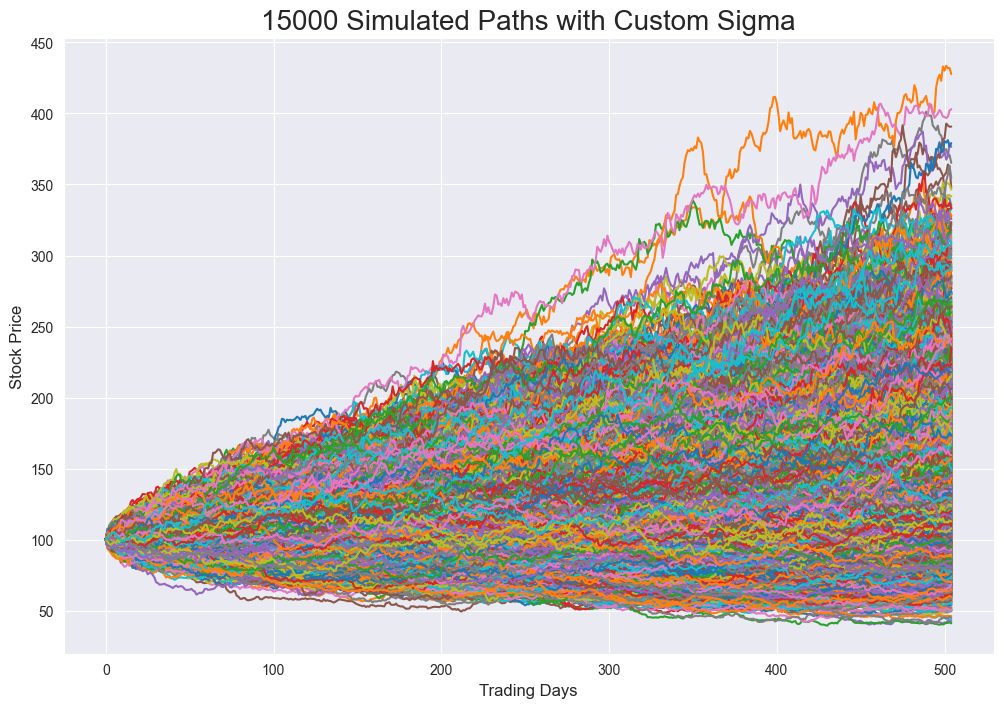

In [3]:
#Each step of the log-returns, there is a 
#    1) 50% the volatility is .2
#    2) 30% chance the volatility is .3
#    3) 20% chance the volatility is .45
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 15000
n_steps = 252*2

#Custom sigma that is not constant
sigma_probs = [.5, .3, .2]
sigma_array = [.2,.3,.45]
sigma = np.random.choice(sigma_array, p = sigma_probs, size = (n_paths, n_steps))
   
simulated_paths = stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps, sigma)

plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)
plt.xlabel('Trading Days', size = 12)
plt.ylabel('Stock Price', size = 12)

plt.savefig("p4 Figure1.png")

plt.show()

In [4]:
sigma

array([[0.2 , 0.3 , 0.45, ..., 0.45, 0.3 , 0.45],
       [0.45, 0.2 , 0.2 , ..., 0.2 , 0.45, 0.3 ],
       [0.3 , 0.3 , 0.45, ..., 0.2 , 0.3 , 0.2 ],
       ...,
       [0.2 , 0.2 , 0.2 , ..., 0.2 , 0.2 , 0.2 ],
       [0.3 , 0.2 , 0.2 , ..., 0.2 , 0.2 , 0.2 ],
       [0.2 , 0.3 , 0.3 , ..., 0.2 , 0.3 , 0.2 ]])

### Simulate stock profits at each interval

I will proceed to simulate a Monte-Carlo simulation of the Black-Scholes value of a call option Delta with different sigma distributions. The parameters for this model are:

| Parameter | Values | 
| --- | --- |
| Current stock price $S(0)$ | 100 | 
| Strike price $K$ | 100 | 
| Risk-free interest rate $r$ | 0.039 |
| Drift term $\mu$ | 0.275 |
| n_paths | 15000 |
| n_hedges| 252*2 |
*Table 1.* Black-Scholes model parameters

and anualized Volatility $\sigma$ selected randomly from the vector $[0.2, 0.3, 0.45]$ with probabilities $[0.5, 0.3, 0.2]$  

In [5]:
S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 15000  #n_sims
n_steps = 252*2    #hedges

delta_sims = 100
K = 100

#Custom sigma that is not constant
sigma_probs = [.5, .3, .2]
sigma_array = [.2, .3, .45]

sigma = np.random.choice(sigma_array, p = sigma_probs, size = (n_paths, n_steps))

profits_hedged = MC_profits_hedged(S0, t, r, mu, n_paths, n_steps, sigma, delta_sims)

In [6]:
print(f'Simulated option value under custom volatility distribution: ${np.mean(profits_hedged):.2f} \
and standard error {np.std(profits_hedged)/np.sqrt(n_paths):.6f}')

sigma_avg = .5*.2 + .3*.3 + .2*.45

print('----'*17)
print('----'*17)

print(f'Black-Scholes Price with volatility the average of custom volatility distribution \
${bs_call(S0, K, sigma_avg, t, r):.2f}.')

Simulated option value under custom volatility distribution: $13.47 and standard error 0.019228
--------------------------------------------------------------------
--------------------------------------------------------------------
Black-Scholes Price with volatility the average of custom volatility distribution $12.94.


## Histogram Showing the distribution of the simulated profits

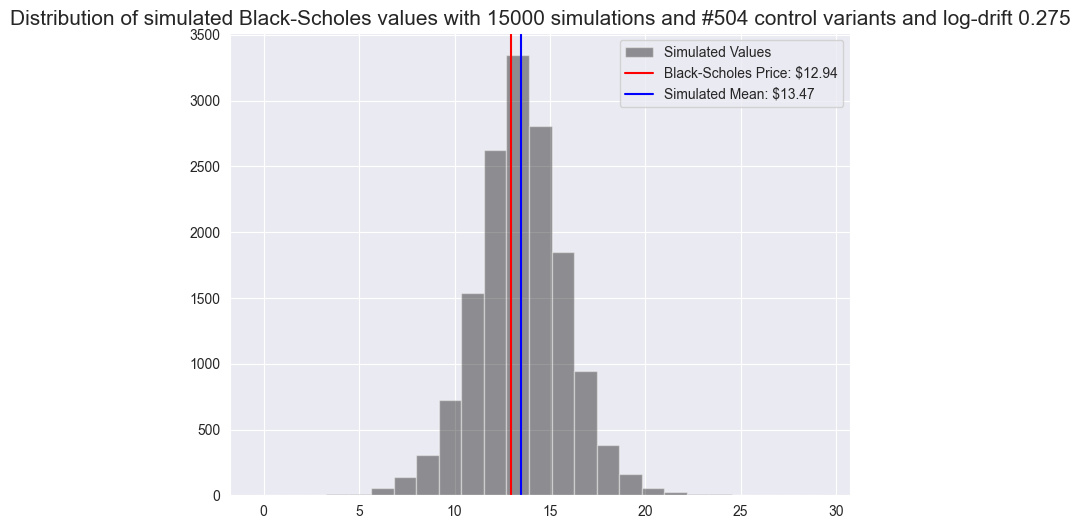

In [7]:
sigma1 = sigma_avg
bs_price1 = bs_call(S0,K,sigma1,t,r)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
plt.axvline(bs_price1, label = f'Black-Scholes Price: ${bs_price1:.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
plt.legend()
    
plt.title(f'Distribution of simulated Black-Scholes values with {n_paths} simulations and \
#{n_steps} control variants and log-drift {mu}',size = 15)
plt.savefig("p4 Figure2.png")

plt.show()